In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import os
from datetime import datetime

warnings.filterwarnings("ignore")
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
nifty_50 = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTY50.csv", parse_dates=["Date"])
nifty_50.set_index("Date", inplace=True)
nifty_50_min_date = nifty_50.index.min()
nifty_50_max_date = nifty_50.index.max()

print(f"nifty_50_min_date: {nifty_50_min_date}")
print(f"nifty_50_max_date: {nifty_50_max_date}")
nifty_50.isna().sum()
nifty_midcap = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTYMid.csv", parse_dates=["Date"])
nifty_midcap.set_index("Date", inplace=True)
nifty_midcap_min_date = nifty_midcap.first_valid_index()
nifty_midcap_max_date = nifty_midcap.last_valid_index()
print(f"nifty_midcap_min_date: {nifty_midcap_min_date}")
print(f"nifty_midcap_max_date: {nifty_midcap_max_date}")
nifty_midcap.isna().sum()
nifty_smallcap = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Equity Benchmark\NIFTYSmall.csv",
                             parse_dates=["Date"])
nifty_smallcap.set_index("Date", inplace=True)
nifty_smallcap_min_date = nifty_smallcap.first_valid_index()
nifty_smallcap_max_date = nifty_smallcap.last_valid_index()

print(f"nifty_smallcap_min_date: {nifty_smallcap_min_date}")
print(f"nigty_smallcap_max_date: {nifty_smallcap_max_date}")
nifty_smallcap.isna().sum()
start_date = nifty_midcap_min_date
end_date = nifty_midcap_max_date
nifty_50[nifty_50.index >= start_date]
nifty_indices = pd.concat([nifty_50, nifty_midcap, nifty_smallcap], axis=1)
nifty_indices = nifty_indices[nifty_indices.index >= start_date]
nifty_indices.isna().sum()
nifty_indices = nifty_indices.dropna()
nifty_indices

nifty_50_min_date: 1995-12-29 00:00:00
nifty_50_max_date: 2025-11-14 00:00:00
nifty_midcap_min_date: 2005-07-18 00:00:00
nifty_midcap_max_date: 2025-11-14 00:00:00
nifty_smallcap_min_date: 2004-01-01 00:00:00
nigty_smallcap_max_date: 2025-11-14 00:00:00


,.NSEI,.NIFMDCP100,.NIFSMCP100
Date,,,
2005-07-18,2234.00,3364.10,1780.51
2005-07-19,2237.30,3396.35,1790.17
2005-07-20,2241.90,3417.05,1794.31
2005-07-21,2230.50,3401.15,1783.65
2005-07-22,2265.60,3440.10,1799.72
...,...,...,...
2025-11-10,25574.35,60124.25,18138.60
2025-11-11,25694.95,60427.00,18101.40
2025-11-12,25875.80,60902.30,18250.45


In [3]:
last_trade_dates = nifty_indices.groupby(nifty_indices.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_index_prices = nifty_indices.loc[last_trade_dates.values]
monthly_index_prices

,.NSEI,.NIFMDCP100,.NIFSMCP100
Date,,,
2005-07-29,2312.30,3408.90,1779.25
2005-08-31,2384.65,3663.05,2043.18
2005-09-30,2601.40,3807.40,2074.62
2005-10-31,2370.95,3478.65,1852.05
2005-11-30,2652.25,3832.50,2065.62
...,...,...,...
2025-07-31,24768.35,57400.55,17966.85
2025-08-29,24426.85,55727.40,17227.00
2025-09-30,24611.10,56529.30,17562.75


In [4]:
cma_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\CMA.csv", parse_dates=["date"])
cma_factor.set_index("date", inplace=True)
cma_factor = cma_factor['close']
cma_factor.rename("CMA", inplace=True)


hml_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\HML.csv",parse_dates=["date"])
hml_factor.set_index("date", inplace=True)
hml_factor = hml_factor['close']
hml_factor.rename("HML", inplace=True)

mkt_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\MKT.csv", parse_dates=["date"])
mkt_factor.set_index("date", inplace=True)
mkt_factor = mkt_factor['close']
mkt_factor.rename("MKT", inplace=True)

mom_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\MOM.csv", parse_dates=["date"])
mom_factor.set_index("date", inplace=True)
mom_factor = mom_factor['close']
mom_factor.rename("MOM", inplace=True)

rmw_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\RMW.csv",parse_dates=["date"])
rmw_factor.set_index("date", inplace=True)
rmw_factor = rmw_factor['close']
rmw_factor.rename("RMW", inplace=True)

sml_big_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\SMB_big.csv",parse_dates=["date"])
sml_big_factor.set_index("date", inplace=True)
sml_big_factor = sml_big_factor['close']
sml_big_factor.rename("SMB_big", inplace=True)

sml_small_factor = pd.read_csv(r"D:\Macro Research\Data\Processed Data\factor_ohlc\SMB_small.csv",parse_dates=["date"])
sml_small_factor.set_index("date", inplace=True)
sml_small_factor = sml_small_factor['close']
sml_small_factor.rename("SMB_small", inplace=True)

factor_indices_df = pd.concat([mkt_factor,cma_factor, mom_factor, rmw_factor, sml_big_factor,sml_small_factor,hml_factor], axis=1)
factor_indices_df



,MKT,CMA,MOM,RMW,SMB_big,SMB_small,HML
date,,,,,,,
2005-01-03,1834.75,1201.23,NaN,NaN,2100.50,NaN,NaN
2005-01-04,1831.30,1201.41,NaN,NaN,2092.80,NaN,NaN
2005-01-05,1769.20,1174.62,NaN,NaN,2021.30,NaN,NaN
2005-01-06,1741.10,1159.74,NaN,NaN,1986.10,NaN,NaN
2005-01-07,1758.05,1166.87,NaN,NaN,2004.00,NaN,NaN
...,...,...,...,...,...,...,...
2025-11-12,23828.15,25551.70,54299.05,5780.00,26495.25,17112.75,15253.25
2025-11-13,23817.45,25565.10,54222.35,5764.65,26512.40,17040.95,15258.95
2025-11-14,23842.30,25557.35,54415.50,5767.35,26534.35,17083.60,15247.10


In [5]:
last_trade_dates = factor_indices_df.groupby(factor_indices_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_factor_prices = factor_indices_df.loc[last_trade_dates.values]
monthly_factor_prices

,MKT,CMA,MOM,RMW,SMB_big,SMB_small,HML
date,,,,,,,
2005-01-31,1768.25,1177.27,NaN,NaN,2033.60,NaN,NaN
2005-02-28,1827.40,1218.40,NaN,NaN,2082.19,NaN,NaN
2005-03-31,1772.85,1182.95,NaN,NaN,2017.20,NaN,NaN
2005-04-29,1688.65,1162.28,974.03,NaN,1887.30,994.01,944.49
2005-05-31,1834.85,1267.72,1047.16,NaN,2067.19,1108.69,1040.17
...,...,...,...,...,...,...,...
2025-07-31,22914.95,24797.10,51947.80,5506.30,25380.50,17144.25,13860.60
2025-08-29,22462.95,24793.00,50200.35,5581.00,25003.05,16506.15,13571.75
2025-09-30,22734.10,24555.30,50575.35,5567.55,25295.15,16692.75,14456.30


In [6]:
eikon_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Economics Data\eikon_cpi_fdi_wpi.csv",
                       parse_dates=["Date"])
eikon_df.set_index("Date", inplace=True)
cpi_df = eikon_df['CPI, Inflation rate']
fdi_df = eikon_df['FDI']
wpi = eikon_df['India, WPI Inflation- Actual, Chg Y/Y']
ind_repo_rate_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Economics Data\indian_repo.csv",
                               parse_dates=["Date"])
ind_repo_rate_df.set_index("Date", inplace=True)
repo_monthly = ind_repo_rate_df.resample("M").ffill()
repo_monthly = repo_monthly.rename(columns={"INRPYLDP Index": "RepoRate"})
repo_monthly = repo_monthly['RepoRate']

# --- Prepare macro data ---
macro = pd.DataFrame({
    "CPI": cpi_df,
    "WPI": wpi,
    "FDI": fdi_df/1000000000,
    "REPO": repo_monthly
})

macro.index = pd.to_datetime(macro.index)
macro.index = macro.index.to_period("M")
macro['CPI change'] = np.log(macro['CPI']).diff()
#macro['WPI change'] = np.log(macro['WPI']).diff()
macro['FDI change'] = (macro['FDI']).diff()
macro['REPO change'] = macro['REPO'].diff()
macro

,CPI,WPI,FDI,REPO,CPI change,FDI change,REPO change
Date,,,,,,,
2000-01,2.619048,NaN,0.119,NaN,NaN,NaN,NaN
2000-02,3.614458,NaN,0.290,NaN,0.322131,0.171,NaN
2000-03,4.830918,NaN,0.257,NaN,0.290095,-0.033,NaN
2000-04,5.542169,NaN,0.083,NaN,0.137349,-0.174,NaN
2000-05,5.011933,NaN,0.349,NaN,-0.100564,0.266,NaN
...,...,...,...,...,...,...,...
2025-06,2.545969,-0.13,2.507,5.5,-0.140718,2.512,-0.5
2025-07,2.662929,-0.58,5.039,5.5,0.044915,2.532,0.0
2025-08,3.155680,0.52,-0.616,5.5,0.169777,-5.655,0.0


In [7]:
ind_10_df = pd.read_csv(
    "D:\Macro Research\Data\Processed Data\Fixed Income Data\India 10-Year Bond Yield Historical Data.csv",
    parse_dates=["Date"], date_format="%d-%m-%Y")
ind_10_df.set_index("Date", inplace=True)
ind_10_df = ind_10_df.sort_index()
ind_10_df = ind_10_df['Price']
ind_2_df = pd.read_csv(
    "D:\Macro Research\Data\Processed Data\Fixed Income Data\India 2-Year Bond Yield Historical Data.csv",
    parse_dates=["Date"], date_format="%d-%m-%Y")
ind_2_df.set_index("Date", inplace=True)
ind_2_df = ind_2_df.sort_index()
ind_2_df = ind_2_df['Price']
ind_10_2_spread = ind_10_df - ind_2_df
us_10_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Fixed Income Data\US_10_yield.csv",
                       parse_dates=["observation_date"])
us_10_df.set_index("observation_date", inplace=True)
us_10_df = us_10_df['DGS10'].ffill()
us_2_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\Fixed Income Data\US_2_yield.csv",
                      parse_dates=["observation_date"])
us_2_df.set_index("observation_date", inplace=True)
us_2_df = us_2_df['DGS2'].ffill()
us_10_2_spread = (us_10_df[us_10_df.index >= "2000-01-01"]) - (us_2_df[us_2_df.index >= "2000-01-01"])
first_trade_dates = us_10_2_spread.groupby(us_10_2_spread.index.to_period("M")).apply(lambda g: g.index[0])
monthly_us_spread = us_10_2_spread.loc[first_trade_dates.values]

# ---- IND SPREAD ----
ind_10_2_spread.index = pd.to_datetime(ind_10_2_spread.index)

# Convert → PeriodIndex(M)
ind_10_2_spread.index = ind_10_2_spread.index.to_period("M")

monthly_us_spread.index = monthly_us_spread.index.to_period("M")

# ---- COMBINE ALL ----
fixed_income = pd.DataFrame({
    "Ind_spread": ind_10_2_spread,
    "Us_spread": monthly_us_spread
})
fixed_income

,Ind_spread,Us_spread
2000-01,NaN,0.20
2000-02,NaN,0.02
2000-03,NaN,-0.13
2000-04,NaN,-0.45
2000-05,NaN,-0.44
...,...,...
2025-07,0.660,0.48
2025-08,0.755,0.54
2025-09,0.849,0.64
2025-10,0.795,0.57


In [8]:
gold_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\GOLD.csv", parse_dates=["Date"])
gold_df.set_index("Date", inplace=True)
gold_df = gold_df['XAU BGN Curncy']
gold_df = gold_df[gold_df.index >= "2005-01-01"]
first_trade_dates = gold_df.groupby(gold_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_gold_df = gold_df.loc[first_trade_dates.values]

silver_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\SILVER.csv", parse_dates=["Date"])
silver_df.set_index("Date", inplace=True)
silver_df = silver_df['XAG BGN Curncy']
silver_df = silver_df[silver_df.index >= "2005-01-01"]
first_trade_dates = silver_df.groupby(silver_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_silver_df = silver_df.loc[first_trade_dates.values]
crude_df = pd.read_csv("D:\Macro Research\Data\Processed Data\Commodity Data\CRUDE.csv", parse_dates=["Date"])
crude_df.set_index("Date", inplace=True)
crude_df = crude_df["CO1 Comdty"]
crude_df = crude_df[crude_df.index >= "2005-01-01"]
first_trade_dates = crude_df.groupby(crude_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_crude_df = crude_df.loc[first_trade_dates.values]

# Convert → PeriodIndex(M)
monthly_gold_df.index = monthly_gold_df.index.to_period("M")
monthly_silver_df.index = monthly_silver_df.index.to_period("M")
monthly_crude_df.index = monthly_crude_df.index.to_period("M")
# ---- COMBINE ALL ----
commodity = pd.DataFrame({
    "Gold" : monthly_gold_df,
    "Silver" : monthly_silver_df,
    "Crude" : monthly_crude_df
})

commodity = np.log(commodity / commodity.shift(1))
commodity

,Gold,Silver,Crude
Date,,,
2005-01,NaN,NaN,NaN
2005-02,0.030413,0.081357,0.086322
2005-03,-0.016899,-0.024984,0.081118
2005-04,0.014025,-0.029959,-0.060751
2005-05,-0.040280,0.069910,-0.007071
...,...,...,...
2025-07,-0.004007,0.016589,0.070244
2025-08,0.046914,0.078685,-0.062729
2025-09,0.112618,0.160758,-0.016280


In [9]:
nifty_valuation_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\valuation_metrics\Nifty 50_01-Jan-1990_02-Dec-2025_2025-12-02_15-59-52.csv", parse_dates=["DATE"])
nifty_valuation_df.set_index("DATE", inplace=True)
first_trade_dates = nifty_valuation_df.groupby(nifty_valuation_df.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_valuation_df = nifty_valuation_df.loc[first_trade_dates.values]

nifty_pe_df = monthly_valuation_df['pe']
nifty_pb_df = monthly_valuation_df['pb']
nifty_div_df = monthly_valuation_df['divYield']

ind_cape_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\cape\ind_cape.csv", parse_dates=["Date"])
ind_cape_df.set_index("Date", inplace=True)
ind_cape_df = ind_cape_df["NIFTY 500 CAPE 10"]

us_cape_df = pd.read_csv(r"D:\Macro Research\Data\Processed Data\cape\us_cape.csv", parse_dates=["Date"])
us_cape_df.set_index("Date", inplace=True)
us_cape_df = us_cape_df["US CAPE"]

nifty_div_df.index = nifty_div_df.index.to_period("M")
nifty_pb_df.index = nifty_pb_df.index.to_period("M")
nifty_pe_df.index = nifty_pe_df.index.to_period("M")
ind_cape_df.index = ind_cape_df.index.to_period("M")
us_cape_df.index = us_cape_df.index.to_period("M")

# ---- COMBINE ALL ----
valuation_metrics = pd.DataFrame({
    "Nifty Div Yield" : nifty_div_df,
    "Nifty PB" : nifty_pb_df,
    "Nifty PE" : nifty_pe_df,
    "Nifty CAPE" : ind_cape_df,
    "S&P CAPE" : us_cape_df
})

valuation_metrics = valuation_metrics[valuation_metrics.index >= "2000-01"]
valuation_metrics


,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE
2000-01,0.98,4.49,25.16,NaN,43.77
2000-02,0.94,4.79,26.36,NaN,42.19
2000-03,1.06,4.46,24.60,NaN,43.22
2000-04,1.77,3.81,21.10,NaN,43.53
2000-05,1.43,4.70,22.96,NaN,41.97
...,...,...,...,...,...
2025-08,1.37,3.27,21.46,39.66,37.96
2025-09,1.35,3.37,21.76,39.80,38.85
2025-10,1.29,3.52,22.64,40.24,39.51
2025-11,1.28,3.56,22.81,NaN,NaN


In [10]:
ind_vix = pd.read_csv(r"D:\Macro Research\Data\Processed Data\vix\Ind_vix_eik.csv", parse_dates=["Exchange Date"])
ind_vix.set_index("Exchange Date", inplace=True)
ind_vix = ind_vix['Close']
ind_vix = ind_vix[~ind_vix.index.duplicated(keep='first')]

last_trade_dates = ind_vix.groupby(ind_vix.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_ind_vix = ind_vix.loc[last_trade_dates.values]
monthly_ind_vix = monthly_ind_vix.drop_duplicates()

us_vix = pd.read_csv(r"D:\Macro Research\Data\Processed Data\vix\us_vix.csv", parse_dates=["Date"])
us_vix.set_index("Date", inplace=True)
us_vix = us_vix[".VIX"]
us_vix = us_vix[~us_vix.index.duplicated(keep='first')]

last_trade_dates = us_vix.groupby(us_vix.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_us_vix = us_vix.loc[last_trade_dates.values]

monthly_ind_vix.index = monthly_ind_vix.index.to_period("M")
monthly_us_vix.index = monthly_us_vix.index.to_period("M")

vix_df = pd.DataFrame({
    "IND VIX" : monthly_ind_vix,
    "US VIX" : monthly_us_vix
})

vix_df["IND VIX chg"] = np.log(vix_df["IND VIX"]).diff()
vix_df["US VIX chg"] = np.log(vix_df["US VIX"]).diff()
vix_df

,IND VIX,US VIX,IND VIX chg,US VIX chg
1995-12,NaN,NaN,NaN,NaN
1996-01,NaN,12.53,NaN,NaN
1996-02,NaN,17.04,NaN,0.307438
1996-03,NaN,18.88,NaN,0.102540
1996-04,NaN,15.83,NaN,-0.176196
...,...,...,...,...
2025-07,11.5425,16.72,-0.102237,-0.000598
2025-08,11.7525,15.36,0.018030,-0.084839
2025-09,11.0650,16.28,-0.060279,0.058171
2025-10,12.1525,17.44,0.093748,0.068829


In [11]:
sp500 = pd.read_csv("D:\Macro Research\Data\Processed Data\Equity Benchmark\SP500.csv", parse_dates=["Date"])
sp500.set_index("Date", inplace=True)
sp500 = sp500[".SPX"]
sp500 = sp500.ffill()

last_trade_dates = sp500.groupby(sp500.index.to_period("M")).apply(lambda g: g.index[-1])
monthly_sp500 = sp500.loc[last_trade_dates.values]

monthly_sp500.index = monthly_sp500.index.to_period("M")

sp500_df = pd.DataFrame({"SP500" : monthly_sp500})
sp500_df = sp500_df[~sp500_df.index.duplicated(keep='first')]

sp500_df = np.log(sp500_df).diff()
sp500_df

,SP500
Date,
1995-12,NaN
1996-01,0.032097
1996-02,0.006910
1996-03,0.007885
1996-04,0.013342
...,...
2025-07,0.021435
2025-08,0.018887
2025-09,0.034714


In [12]:
# Combine everything column-wise
macro_full = pd.concat([
    macro,
    fixed_income,
    commodity,
    valuation_metrics,
    vix_df,
    sp500_df
], axis=1)

macro_full = macro_full.sort_index()

macro_full = macro_full[macro_full.index >= "2005-01"]
macro_full = macro_full.ffill(limit=1)
macro_full

,CPI,WPI,FDI,REPO,CPI change,FDI change,REPO change,Ind_spread,Us_spread,Gold,Silver,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
2005-01,4.365079,NaN,0.152,4.75,0.142627,-0.164,0.00,NaN,1.13,NaN,NaN,NaN,1.94,3.57,14.68,NaN,26.59,NaN,12.82,NaN,-0.036005,-0.025616
2005-02,4.166667,NaN,0.238,4.75,-0.046520,0.086,0.00,NaN,0.86,0.030413,0.081357,0.086322,1.90,3.92,15.02,NaN,26.74,NaN,12.08,NaN,-0.059455,0.018727
2005-03,4.166667,NaN,0.275,4.75,0.000000,0.037,0.00,NaN,0.79,-0.016899,-0.024984,0.081118,1.97,3.82,14.60,NaN,26.34,NaN,14.02,NaN,0.148934,-0.019303
2005-04,4.960317,NaN,0.268,6.00,0.174353,-0.007,1.25,NaN,0.71,0.014025,-0.029959,-0.060751,2.11,3.56,13.27,NaN,25.41,NaN,15.31,NaN,0.088021,-0.020314
2005-05,3.740157,NaN,0.654,6.00,-0.282342,0.386,0.00,NaN,0.57,-0.040280,0.069910,-0.007071,1.97,3.91,13.94,NaN,25.65,NaN,13.29,NaN,-0.141494,0.029512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08,3.155680,0.52,-0.616,5.50,0.169777,-5.655,0.00,0.755,0.54,0.046914,0.078685,-0.062729,1.37,3.27,21.46,39.66,37.96,11.7525,15.36,0.018030,-0.084839,0.018887
2025-09,2.791347,0.13,-0.616,5.50,-0.122680,-5.655,0.00,0.849,0.64,0.112618,0.160758,-0.016280,1.35,3.37,21.76,39.80,38.85,11.0650,16.28,-0.060279,0.058171,0.034714
2025-10,2.791347,-1.21,NaN,5.50,-0.122680,NaN,0.00,0.795,0.57,0.036626,0.042876,-0.029527,1.29,3.52,22.64,40.24,39.51,12.1525,17.44,0.093748,0.068829,0.022433
2025-11,NaN,-1.21,NaN,5.50,NaN,NaN,0.00,0.723,0.53,0.040302,0.077684,-0.022693,1.28,3.56,22.81,40.24,39.51,11.7875,19.83,-0.030495,0.128430,-0.015631


In [13]:
macro_full

,CPI,WPI,FDI,REPO,CPI change,FDI change,REPO change,Ind_spread,Us_spread,Gold,Silver,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
2005-01,4.365079,NaN,0.152,4.75,0.142627,-0.164,0.00,NaN,1.13,NaN,NaN,NaN,1.94,3.57,14.68,NaN,26.59,NaN,12.82,NaN,-0.036005,-0.025616
2005-02,4.166667,NaN,0.238,4.75,-0.046520,0.086,0.00,NaN,0.86,0.030413,0.081357,0.086322,1.90,3.92,15.02,NaN,26.74,NaN,12.08,NaN,-0.059455,0.018727
2005-03,4.166667,NaN,0.275,4.75,0.000000,0.037,0.00,NaN,0.79,-0.016899,-0.024984,0.081118,1.97,3.82,14.60,NaN,26.34,NaN,14.02,NaN,0.148934,-0.019303
2005-04,4.960317,NaN,0.268,6.00,0.174353,-0.007,1.25,NaN,0.71,0.014025,-0.029959,-0.060751,2.11,3.56,13.27,NaN,25.41,NaN,15.31,NaN,0.088021,-0.020314
2005-05,3.740157,NaN,0.654,6.00,-0.282342,0.386,0.00,NaN,0.57,-0.040280,0.069910,-0.007071,1.97,3.91,13.94,NaN,25.65,NaN,13.29,NaN,-0.141494,0.029512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08,3.155680,0.52,-0.616,5.50,0.169777,-5.655,0.00,0.755,0.54,0.046914,0.078685,-0.062729,1.37,3.27,21.46,39.66,37.96,11.7525,15.36,0.018030,-0.084839,0.018887
2025-09,2.791347,0.13,-0.616,5.50,-0.122680,-5.655,0.00,0.849,0.64,0.112618,0.160758,-0.016280,1.35,3.37,21.76,39.80,38.85,11.0650,16.28,-0.060279,0.058171,0.034714
2025-10,2.791347,-1.21,NaN,5.50,-0.122680,NaN,0.00,0.795,0.57,0.036626,0.042876,-0.029527,1.29,3.52,22.64,40.24,39.51,12.1525,17.44,0.093748,0.068829,0.022433
2025-11,NaN,-1.21,NaN,5.50,NaN,NaN,0.00,0.723,0.53,0.040302,0.077684,-0.022693,1.28,3.56,22.81,40.24,39.51,11.7875,19.83,-0.030495,0.128430,-0.015631


In [14]:
# Crisis indicator: weighted sum of normalized stress signals
stress_factors = pd.DataFrame({
    'ind_vix_zscore': (macro_full['IND VIX'] - macro_full['IND VIX'].rolling(12).mean()) / macro_full['IND VIX'].rolling(12).std(),
    'us_vix_zscore': (macro_full['US VIX'] - macro_full['US VIX'].rolling(12).mean()) / macro_full['US VIX'].rolling(12).std(),
    'ind_credit_spread_zscore': (macro_full['Ind_spread'] - macro_full['Ind_spread'].mean()) / macro_full['Ind_spread'].std(),
    'us_vix_zscore': (macro_full['Us_spread'] - macro_full['Us_spread'].mean()) / macro_full['Us_spread'].std(),
    'liquidity_proxy': -macro_full['FDI change'],  # Negative FDI = liquidity stress
})
macro_state = pd.DataFrame()
macro_state['stress_score'] = stress_factors.mean(axis=1)
macro_state

,stress_score
2005-01,0.165986
2005-02,-0.100881
2005-03,-0.113161
2005-04,-0.133196
2005-05,-0.403257
...,...
2025-08,1.069170
2025-09,1.093491
2025-10,-0.270553
2025-11,-0.337666


In [15]:
# Clean final macro feature matrix
macro_features = macro_full.dropna().copy()
macro_features = macro_features.astype(float)
# Standardize
scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_features)
macro_scaled = pd.DataFrame(macro_scaled, index=macro_features.index, columns=macro_features.columns)
macro_scaled

,CPI,WPI,FDI,REPO,CPI change,FDI change,REPO change,Ind_spread,Us_spread,Gold,Silver,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
2008-04,0.355852,0.770858,0.629517,1.128178,-0.000808,-0.237713,0.045212,-0.697661,0.712141,-1.052481,-0.286220,0.992879,-1.684886,4.024809,-0.077967,1.167124,-0.674826,0.719067,0.100002,-1.402929,-0.881840,0.839091
2008-05,0.335384,0.975095,0.712050,1.128178,-0.000413,0.063457,0.045212,-0.749938,0.342263,0.072138,-0.034862,1.297932,-1.083054,2.948272,-0.409261,1.230125,-0.616118,0.777551,-0.253185,0.127842,-0.647832,0.060711
2008-06,0.315232,1.676604,0.017510,1.706659,-0.000024,-0.531629,3.520887,-1.776480,0.403909,0.755045,0.299227,0.858732,0.220917,0.934749,-1.210854,0.582474,-0.837138,1.258915,0.477052,0.755627,1.263881,-2.122397
2008-07,0.531873,1.794262,-0.047885,2.092312,0.567952,-0.049827,2.362329,-1.114297,0.311439,-0.394963,0.170443,-1.090018,-0.130152,0.914813,-0.993080,0.127606,-1.097872,2.169910,0.356539,1.162261,-0.177000,-0.385157
2008-08,0.764804,1.727663,-0.011354,2.092312,0.564208,0.028228,0.045212,-1.561033,0.393634,-2.119913,-2.999758,-0.748991,-0.080000,0.595839,-0.944429,0.315350,-1.013263,1.338768,0.083297,-0.987745,-0.441513,0.093277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05,-1.294018,-0.880795,-1.063538,-0.221610,0.026779,-1.334287,0.045212,-0.075082,-0.541335,-0.135726,0.079676,0.137892,-0.280611,0.177186,-0.043216,1.731614,1.348886,-0.414896,-0.164888,-0.576872,-1.208835,1.127008
2025-06,-1.424030,-0.996234,0.069375,-0.607263,-0.860717,0.867842,-2.271904,-0.032309,-0.572158,-0.051403,0.962812,0.546812,-0.330763,0.336673,0.107373,1.799655,1.526738,-0.785198,-0.384437,-1.082176,-0.438006,0.881768
2025-07,-1.384502,-1.096132,1.211307,-0.607263,0.340623,0.874749,0.045212,0.127692,-0.613256,-0.222583,0.139821,0.674687,0.371375,-0.301275,-0.133569,1.759334,1.761572,-0.924940,-0.385630,-0.465030,0.004034,0.295693
2025-08,-1.217972,-0.851936,-1.339099,-0.607263,1.148676,-1.952858,0.045212,0.278188,-0.551610,0.837678,0.830745,-0.556789,0.321222,-0.520569,-0.242456,1.577891,1.846181,-0.901322,-0.547905,0.119806,-0.354900,0.240341


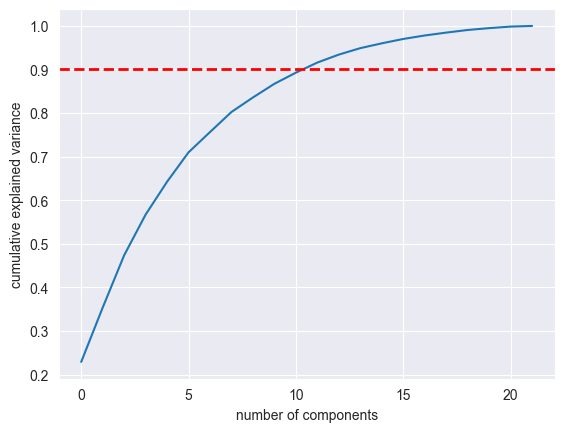

In [44]:
pca = PCA()
macro_pca = pca.fit_transform(macro_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.90, color='r', linestyle='--', linewidth=2, label='y = 0.90')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [45]:
# PCA retain 95% variance
pca = PCA(n_components=0.90)
macro_pca = pca.fit_transform(macro_scaled)

macro_pca_df = pd.DataFrame(macro_pca, index=macro_features.index)
print("Number of PCA components retained:", macro_pca_df.shape[1])

Number of PCA components retained: 12


In [46]:
# 1. Get the feature names from your scaled data
feature_names = macro_scaled.columns

# 2. Extract the loadings (weights) from the fitted PCA object
# Shape is (n_components, n_features)
loadings = pca.components_

# 3. Identify the feature with the highest absolute loading for each PC
most_important_features = []
for i in range(loadings.shape[0]):
    # Find index of max absolute loading
    max_col_index = np.argmax(np.abs(loadings[i]))
    feature_name = feature_names[max_col_index]
    most_important_features.append(feature_name)

# 4. Rename the columns of your PCA DataFrame
new_column_names = [f"PC{i+1}_{name}" for i, name in enumerate(most_important_features)]
macro_pca_df.columns = new_column_names

# Display the result
print("Dominant Macro Factors per PC:")
print(macro_pca_df.columns.tolist())
display(macro_pca_df.head())

Dominant Macro Factors per PC:
['PC1_S&P CAPE', 'PC2_SP500', 'PC3_Ind_spread', 'PC4_WPI', 'PC5_FDI', 'PC6_Gold', 'PC7_CPI change', 'PC8_US VIX chg', 'PC9_IND VIX chg', 'PC10_Crude', 'PC11_WPI', 'PC12_REPO change']


,PC1_S&P CAPE,PC2_SP500,PC3_Ind_spread,PC4_WPI,PC5_FDI,PC6_Gold,PC7_CPI change,PC8_US VIX chg,PC9_IND VIX chg,PC10_Crude,PC11_WPI,PC12_REPO change
2008-04,1.567376,1.478204,0.212173,2.574576,-0.285474,-0.141906,-0.170763,-2.263110,0.461108,-0.370769,-1.976913,0.752534
2008-05,0.965286,0.837547,0.213827,1.790745,0.167449,1.075956,0.006853,-1.871492,0.995048,0.431289,-1.481679,0.071781
2008-06,-1.438668,-0.480381,-0.926638,2.774317,0.002136,3.843600,-0.602538,-0.490934,-0.408599,2.145176,0.272364,1.355869
2008-07,-1.963118,0.013450,-0.534419,2.570732,-0.091726,1.959729,0.270584,-1.584963,1.524872,0.733112,0.829641,1.639559
2008-08,-2.159069,0.230899,-1.797192,3.132332,0.064499,-1.512832,0.357564,-2.597003,0.007508,-0.380717,-0.232310,0.184472


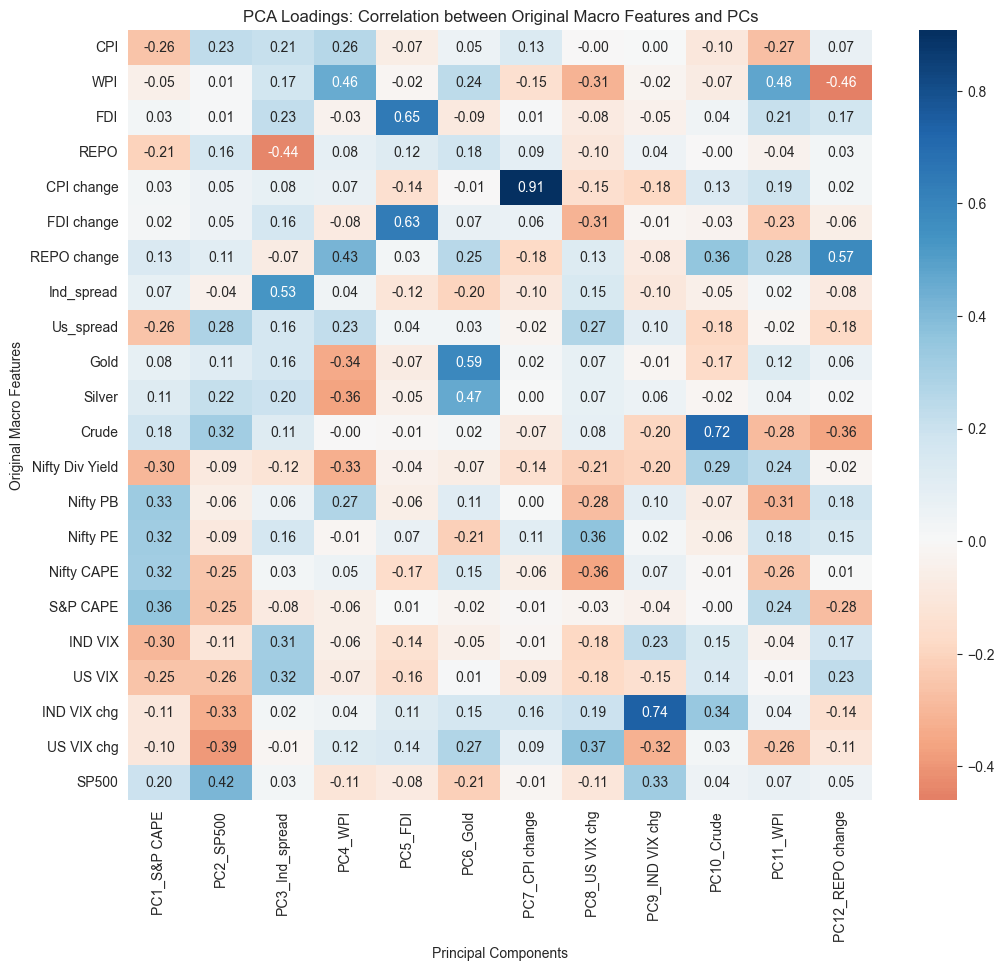

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(
    pca.components_.T,
    index=feature_names,
    columns=new_column_names
)

plt.figure(figsize=(12, 10))
sns.heatmap(loadings_df, annot=True, cmap='RdBu', fmt=".2f", center=0)
plt.title("PCA Loadings: Correlation between Original Macro Features and PCs")
plt.xlabel("Principal Components")
plt.ylabel("Original Macro Features")
plt.show()

In [48]:
kmeans_layer1 = KMeans(n_clusters=2, random_state=42)
layer1_labels = kmeans_layer1.fit_predict(macro_pca_df)

df_layer1 = pd.DataFrame({
    "Regime_L1": layer1_labels
}, index=macro_pca_df.index)

# Identify small cluster as crisis regime (Regime 0)
cluster_sizes = df_layer1["Regime_L1"].value_counts()
regime0_label = cluster_sizes.idxmin()

df_layer1["Regime_L1"] = (df_layer1["Regime_L1"] == regime0_label).astype(int)


In [49]:
from sklearn.metrics.pairwise import cosine_similarity

normal_idx = df_layer1[df_layer1["Regime_L1"] == 0].index
normal_pca = macro_pca_df.loc[normal_idx]

# Try k = 3 to 6 and pick best silhouette
best_k = 0
best_score = -999

for k in range(3, 7):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(normal_pca)
    score = silhouette_score(normal_pca, labels)

    if score > best_score:
        best_k = k
        best_score = score

print("Optimal k for normal regimes:", best_k)

# Final model
kmeans_layer2 = KMeans(n_clusters=best_k, random_state=42)
layer2_labels = kmeans_layer2.fit_predict(normal_pca)


Optimal k for normal regimes: 3


In [50]:
df_layer2 = pd.DataFrame({"Regime_L2": layer2_labels}, index=normal_idx)

# Merge with layer1
regime_df = pd.DataFrame(index=macro_pca_df.index)

regime_df["Regime_Final"] = 0
# Identify normal-month indices
normal_idx = df_layer2.index

# Assign layer-2 regimes + 1 (starting from 1)
regime_df.loc[normal_idx, "Regime_Final"] = df_layer2["Regime_L2"] + 1


In [51]:
regime_df

,Regime_Final
2008-04,1
2008-05,1
2008-06,0
2008-07,0
2008-08,0
...,...
2025-05,1
2025-06,1
2025-07,1
2025-08,1


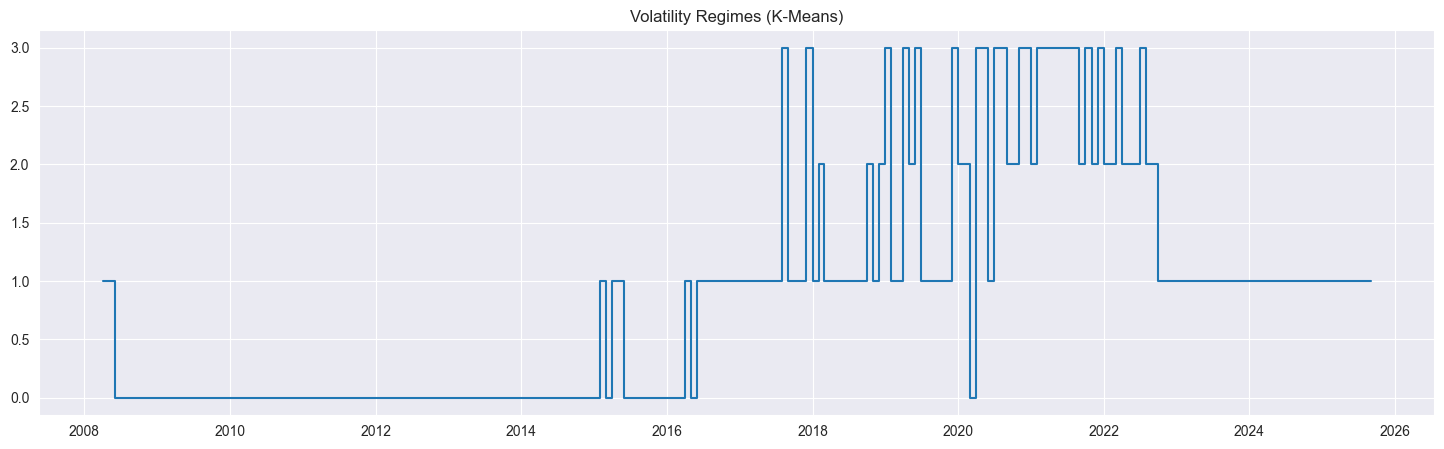

In [52]:
##%% ============================================
# 8. TIME-SERIES PLOT OF REGIMES
# ===============================================
plt.figure(figsize=(18,5))
plt.plot(regime_df.index.to_timestamp(), regime_df, drawstyle='steps-post')
plt.title("Volatility Regimes (K-Means)")
#plt.yticks(range(K_FINAL), [f"Regime {i}" for i in range(K_FINAL)])
plt.grid(True)
plt.show()


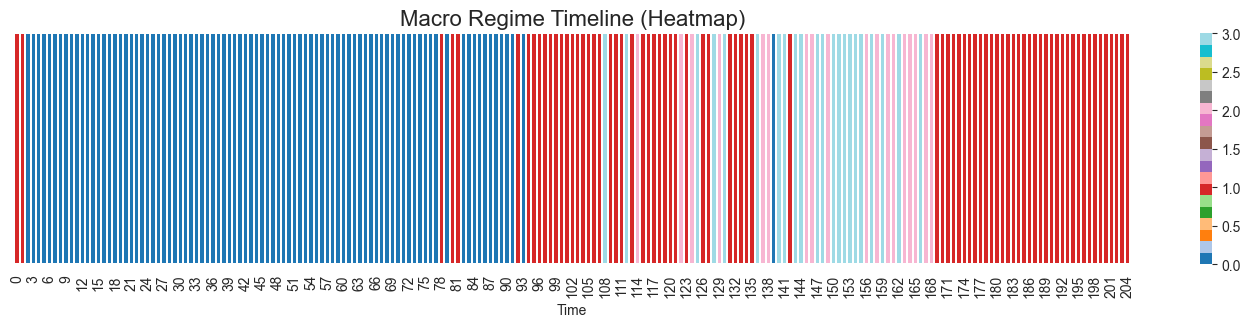

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap data
regime_heatmap = pd.DataFrame({"Regime": regime_df["Regime_Final"]})
regime_heatmap.index = regime_heatmap.index.to_timestamp()

plt.figure(figsize=(18, 3))
sns.heatmap([regime_heatmap["Regime"].values],
            cmap="tab20",
            cbar=True,
            linewidths=0.1)

plt.yticks([], [])
plt.title("Macro Regime Timeline (Heatmap)", fontsize=16)
plt.xlabel("Time")
plt.show()


In [54]:
regime_df

,Regime_Final
2008-04,1
2008-05,1
2008-06,0
2008-07,0
2008-08,0
...,...
2025-05,1
2025-06,1
2025-07,1
2025-08,1


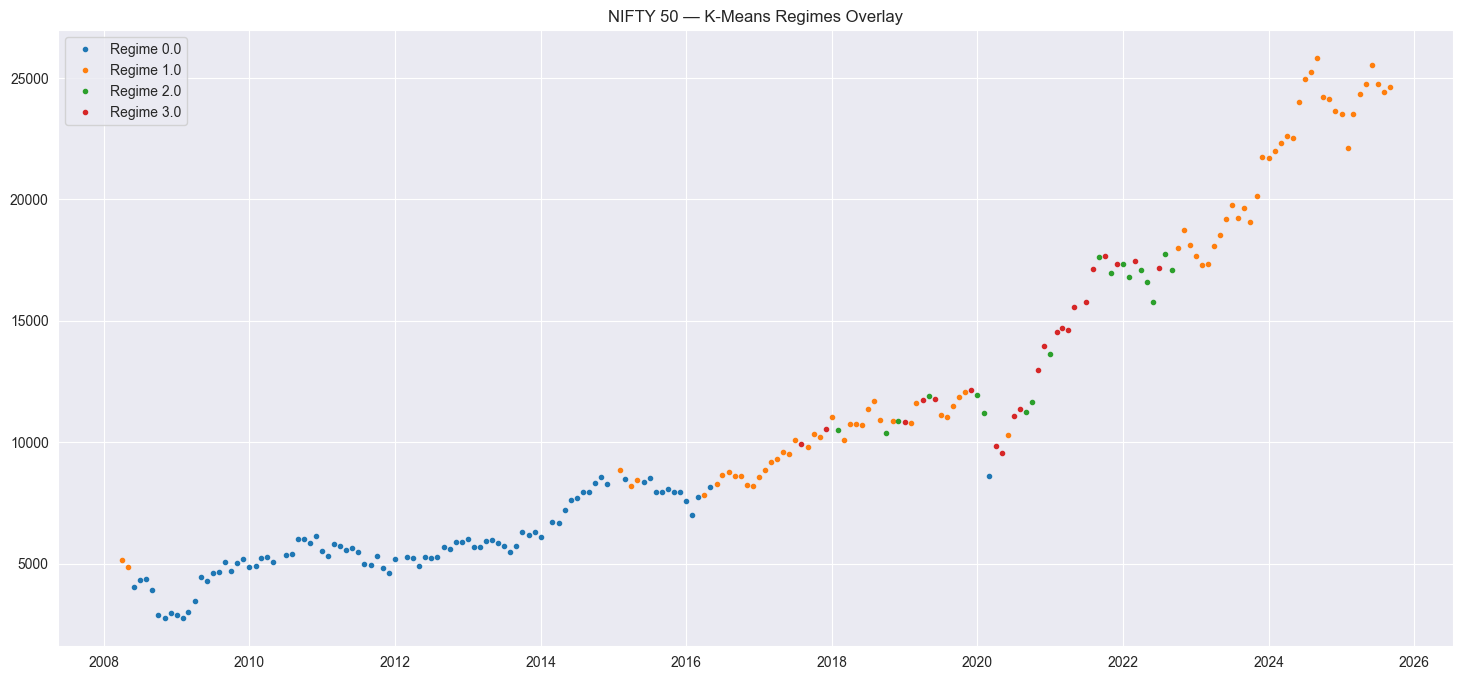

In [55]:
# ensure timestamp index
plot_df = pd.concat([monthly_index_prices.to_period('M'), regime_df], axis=1)
plot_df = plot_df.dropna(subset=["Regime_Final"])

plot_df = plot_df.copy()
plot_df.index = plot_df.index.to_timestamp()

plt.figure(figsize=(18, 8))

for r in sorted(plot_df["Regime_Final"].unique()):
    mask = plot_df["Regime_Final"] == r
    plt.plot(
        plot_df.index[mask],
        plot_df[".NSEI"][mask],  # replace with correct column
        ".",
        markersize=6,
        label=f"Regime {r}"
    )

plt.title("NIFTY 50 — K-Means Regimes Overlay")
plt.legend()
plt.grid(True)
plt.show()


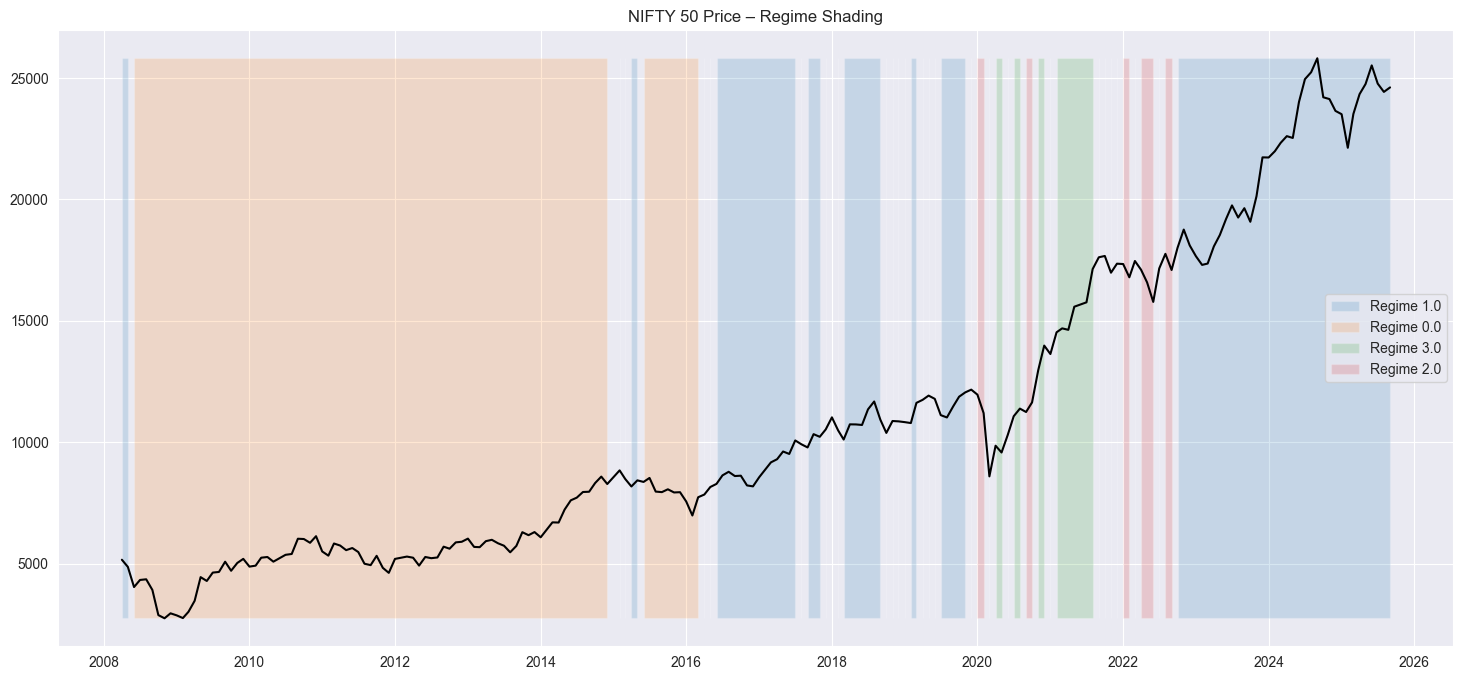

In [56]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(plot_df.index, plot_df[".NSEI"], color="black", linewidth=1.5)

for r in plot_df["Regime_Final"].unique():
    mask = plot_df["Regime_Final"] == r
    ax.fill_between(
        plot_df.index,
        plot_df[".NSEI"].min(),
        plot_df[".NSEI"].max(),
        where=mask,
        alpha=0.18,
        label=f"Regime {r}"
    )

ax.set_title("NIFTY 50 Price – Regime Shading")
ax.legend()
plt.show()


In [57]:
# Calculate average macro feature values by regime
regime_features = macro_full.groupby(regime_df["Regime_Final"]).mean()

# Precompute quantiles across regimes
feature_quantiles = regime_features.quantile([0.25, 0.5, 0.75])

# Calculate average macro feature values by regime
regime_features = macro_full.groupby(regime_df["Regime_Final"]).mean()

# Quantiles of each feature across regimes
feature_quantiles = regime_features.quantile([0.25, 0.5, 0.75])

interpretation = {}

for r in regime_features.index:
    attrs = regime_features.loc[r]
    desc = []

    # High Volatility (India)
    if attrs["IND VIX"] > feature_quantiles.loc[0.75, "IND VIX"]:
        desc.append("High Volatility (India)")

    # High Volatility (US)
    if attrs["US VIX"] > feature_quantiles.loc[0.75, "US VIX"]:
        desc.append("High Volatility (US)")

    # Yield Curve Inversion (India)
    if attrs["Ind_spread"] < feature_quantiles.loc[0.25, "Ind_spread"]:
        desc.append("India Curve Inversion / Tightening")

    # Yield Curve Inversion (US)
    if attrs["Us_spread"] < feature_quantiles.loc[0.25, "Us_spread"]:
        desc.append("US Curve Inversion / Tightening")

    # Liquidity tightening
    if attrs["FDI change"] < feature_quantiles.loc[0.25, "FDI change"]:
        desc.append("Liquidity Tightening (FDI↓)")

    # Commodity inflation pressure
    if attrs["Crude"] > feature_quantiles.loc[0.75, "Crude"]:
        desc.append("High Commodity Inflation (Crude↑)")

    # Equity expensive
    if attrs["Nifty PE"] > feature_quantiles.loc[0.75, "Nifty PE"]:
        desc.append("Expensive Indian Equities")

    # Equity cheap
    if attrs["Nifty PE"] < feature_quantiles.loc[0.25, "Nifty PE"]:
        desc.append("Cheap Indian Equities")

    # Fallback
    if len(desc) == 0:
        desc = ["Normal / Neutral"]

    interpretation[r] = desc

# Print readable mapping
print("\n=== ECONOMIC INTERPRETATION OF REGIMES ===\n")
for r, desc in interpretation.items():
    print(f"Regime {r}: {', '.join(desc)}")



=== ECONOMIC INTERPRETATION OF REGIMES ===

Regime 0.0: High Volatility (India), Cheap Indian Equities
Regime 1.0: India Curve Inversion / Tightening, US Curve Inversion / Tightening
Regime 2.0: High Volatility (US), Liquidity Tightening (FDI↓)
Regime 3.0: High Commodity Inflation (Crude↑), Expensive Indian Equities


In [58]:
regime_features

,CPI,WPI,FDI,REPO,CPI change,FDI change,REPO change,Ind_spread,Us_spread,Gold,Silver,Crude,Nifty Div Yield,Nifty PB,Nifty PE,Nifty CAPE,S&P CAPE,IND VIX,US VIX,IND VIX chg,US VIX chg,SP500
Regime_Final,,,,,,,,,,,,,,,,,,,,,,
0.0,9.133241,5.177303,2.157326,6.998876,-0.006835,-0.030506,-0.016854,0.507640,1.968989,0.001921,-0.006553,-0.026166,1.370562,3.246067,19.525393,21.229551,21.922697,23.914270,22.193146,0.001017,0.005735,0.002247
1.0,4.554392,2.120658,1.717408,6.281579,-0.018165,-0.376289,-0.016447,0.308303,0.296842,0.010454,0.012413,0.012570,1.268158,3.713158,23.548947,31.852895,30.801316,14.845428,15.677895,-0.010236,-0.032078,0.016612
2.0,5.785914,8.022778,3.403111,4.883333,-0.024509,-1.011500,0.105556,1.123056,0.403889,-0.004892,-0.032357,-0.040895,1.276111,3.829444,25.478333,32.318889,32.218333,20.355000,27.374444,0.095625,0.310445,-0.050489
3.0,5.571435,5.770455,4.482727,4.577273,0.038537,2.244091,-0.052273,1.361364,0.713182,0.022387,0.047583,0.071587,1.199545,3.811364,28.534091,30.506818,32.637273,19.505455,19.576818,-0.108556,-0.180778,0.047727


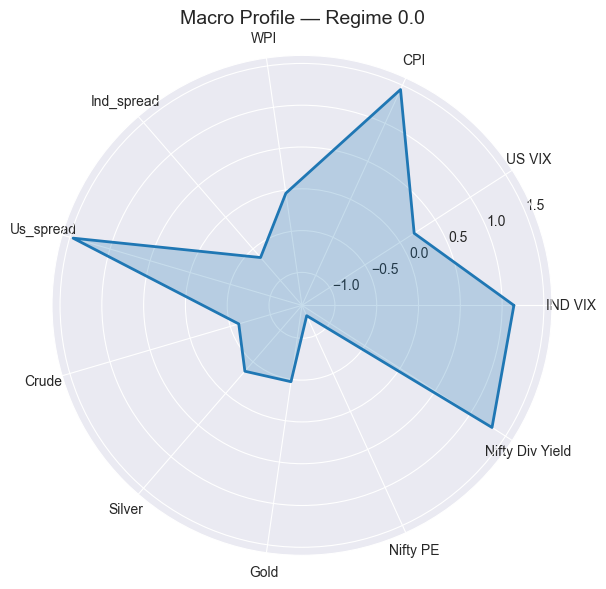

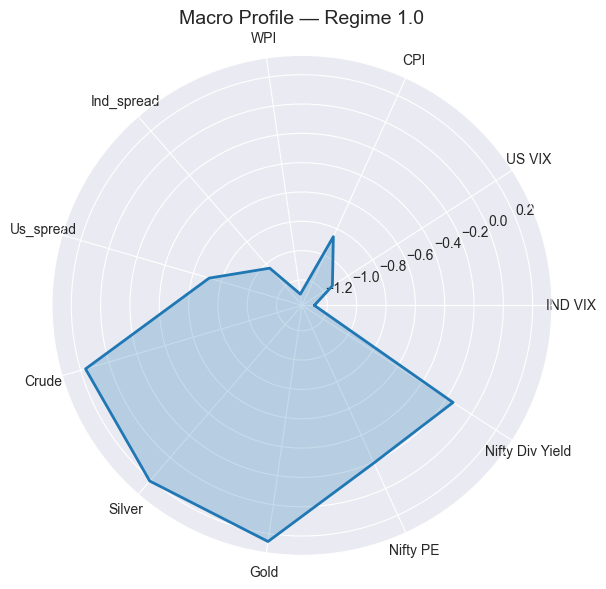

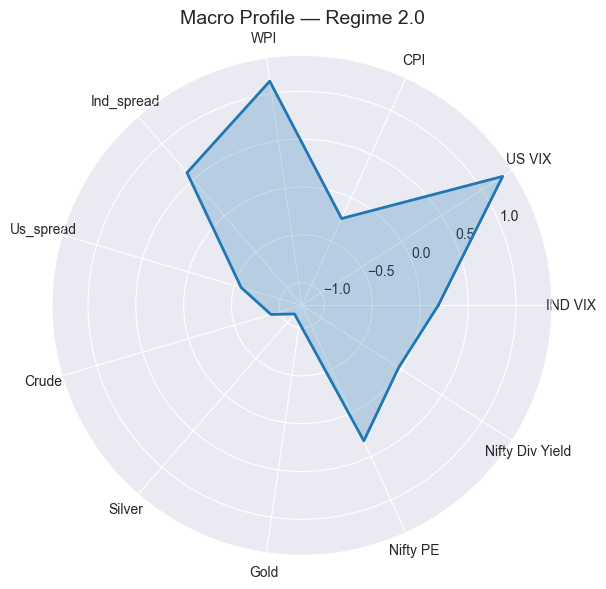

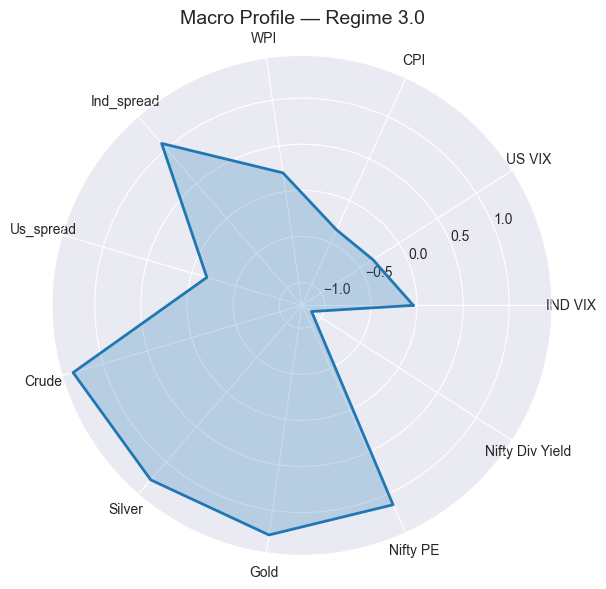

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Normalize features for radar chart
radar_df = (regime_features - regime_features.mean()) / regime_features.std()
radar_df = radar_df.fillna(0)

# Select key features to display (you can expand this list)
radar_features = [
    "IND VIX", "US VIX",
    "CPI", "WPI",
    "Ind_spread", "Us_spread",
    "Crude", "Silver", "Gold",
    "Nifty PE", "Nifty Div Yield",
]

radar_df_small = radar_df[radar_features]

# Radar plot generator
def plot_radar(values, title, feature_labels):
    N = len(feature_labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    values = values.tolist()
    values += values[:1]

    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], feature_labels, size=10)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    plt.title(title, size=14)
    plt.tight_layout()
    plt.show()

# Plot radar for each regime
for r in radar_df_small.index:
    plot_radar(
        radar_df_small.loc[r].values,
        f"Macro Profile — Regime {r}",
        radar_features
    )


In [60]:
# Compute global mean and std
global_mean = macro_full.mean()
global_std = macro_full.std()

# Initialize feature importance DF correctly
feature_importance = pd.DataFrame(
    index=regime_features.index,
    columns=macro_full.columns,
    dtype=float
)

# Compute importance = |regime centroid - global_mean| / global_std
for r in regime_features.index:
    importance_r = abs((regime_features.loc[r] - global_mean) / global_std)
    feature_importance.loc[r] = importance_r

# Sort top explanatory variables for each regime
top_features = {}

for r in feature_importance.index:
    top = feature_importance.loc[r].sort_values(ascending=False).head(10)
    top_features[r] = top

    print(f"\n===== TOP FEATURES DEFINING REGIME {r} =====")
    print(top)



===== TOP FEATURES DEFINING REGIME 0.0 =====
Us_spread     1.049636
S&P CAPE      0.956844
CPI           0.902618
Nifty CAPE    0.838561
Nifty PB      0.679213
Nifty PE      0.551526
REPO          0.492004
IND VIX       0.474312
US VIX        0.367547
Crude         0.267794
Name: 0.0, dtype: float64

===== TOP FEATURES DEFINING REGIME 1.0 =====
CPI           0.727834
Us_spread     0.707565
S&P CAPE      0.668723
IND VIX       0.548186
WPI           0.531663
US VIX        0.442423
Ind_spread    0.428249
Nifty CAPE    0.420365
Nifty PE      0.370793
SP500         0.228458
Name: 1.0, dtype: float64

===== TOP FEATURES DEFINING REGIME 2.0 =====
US VIX chg    1.397222
SP500         1.324918
REPO          1.173971
US VIX        1.011680
S&P CAPE      0.928161
Ind_spread    0.871355
WPI           0.843610
Nifty PE      0.813066
Us_spread     0.595074
FDI           0.587584
Name: 2.0, dtype: float64

===== TOP FEATURES DEFINING REGIME 3.0 =====
Nifty PE           1.513536
REPO               1

In [61]:
interpretive_summary = pd.DataFrame(index=regime_features.index)

for r in regime_features.index:
    desc = []

    # Volatility
    if regime_features.loc[r, "IND VIX"] > regime_features["IND VIX"].mean():
        desc.append("India Vol ↑")
    if regime_features.loc[r, "US VIX"] > regime_features["US VIX"].mean():
        desc.append("US Vol ↑")

    # Inflation
    if regime_features.loc[r, "CPI"] > regime_features["CPI"].mean():
        desc.append("CPI ↑")
    if regime_features.loc[r, "WPI"] > regime_features["WPI"].mean():
        desc.append("WPI ↑")

    # Yield Curve
    if regime_features.loc[r, "Ind_spread"] < regime_features["Ind_spread"].mean():
        desc.append("IN Yield Curve Inversion")
    if regime_features.loc[r, "Us_spread"] < regime_features["Us_spread"].mean():
        desc.append("US Yield Curve Inversion")

    # Liquidity
    if regime_features.loc[r, "FDI change"] < 0:
        desc.append("Liquidity Tightening")

    # Commodities
    if regime_features.loc[r, "Crude"] > regime_features["Crude"].mean():
        desc.append("Crude ↑ (Commodity Inflation)")

    # Valuation
    if regime_features.loc[r, "Nifty PE"] > regime_features["Nifty PE"].mean():
        desc.append("Nifty Valuation High")
    if regime_features.loc[r, "Nifty Div Yield"] < regime_features["Nifty Div Yield"].mean():
        desc.append("Dividend Yield Low")

    interpretive_summary.loc[r, "Summary"] = ", ".join(desc)

print("\n=== REGIME INTERPRETATION TABLE ===\n")
display(interpretive_summary)



=== REGIME INTERPRETATION TABLE ===



,Summary
Regime_Final,
0.0,"India Vol ↑, US Vol ↑, CPI ↑, IN Yield Curve I..."
1.0,"IN Yield Curve Inversion, US Yield Curve Inver..."
2.0,"India Vol ↑, US Vol ↑, WPI ↑, US Yield Curve I..."
3.0,"WPI ↑, US Yield Curve Inversion, Crude ↑ (Comm..."


In [62]:
def fuzzy_probabilities(x, centroids):
    dists = np.linalg.norm(centroids - x, axis=1)
    inv = 1 - dists / dists.sum()
    probs = inv / inv.sum()
    return probs

# Build centroids
centroids = np.vstack([kmeans_layer1.cluster_centers_,
                       kmeans_layer2.cluster_centers_])

# Compute fuzzy probabilities for each month
probs = []
for i in range(len(macro_pca_df)):
    x = macro_pca_df.iloc[i].values
    p = fuzzy_probabilities(x, centroids)
    probs.append(p)

probs = np.array(probs)
prob_df = pd.DataFrame(probs, index=macro_pca_df.index)


In [63]:
regimes = regime_df["Regime_Final"]
regime_list = sorted(regimes.unique())
K = len(regime_list)

transition = pd.DataFrame(0, index=regime_list, columns=regime_list)

for (r1, r2) in zip(regimes[:-1], regimes[1:]):
    transition.loc[r1, r2] += 1

transition = transition.div(transition.sum(axis=1), axis=0).fillna(0)


In [64]:
def predict_next_regime(p):
    return p @ transition.values


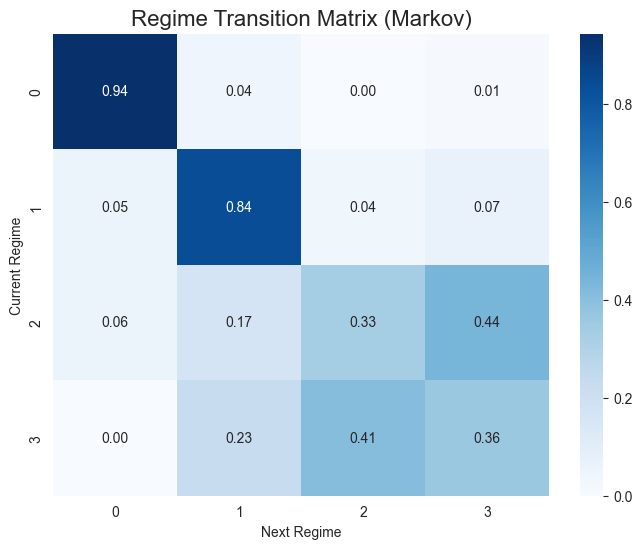

In [65]:
plt.figure(figsize=(8, 6))
sns.heatmap(transition, annot=True, cmap="Blues", fmt=".2f")
plt.title("Regime Transition Matrix (Markov)", fontsize=16)
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()


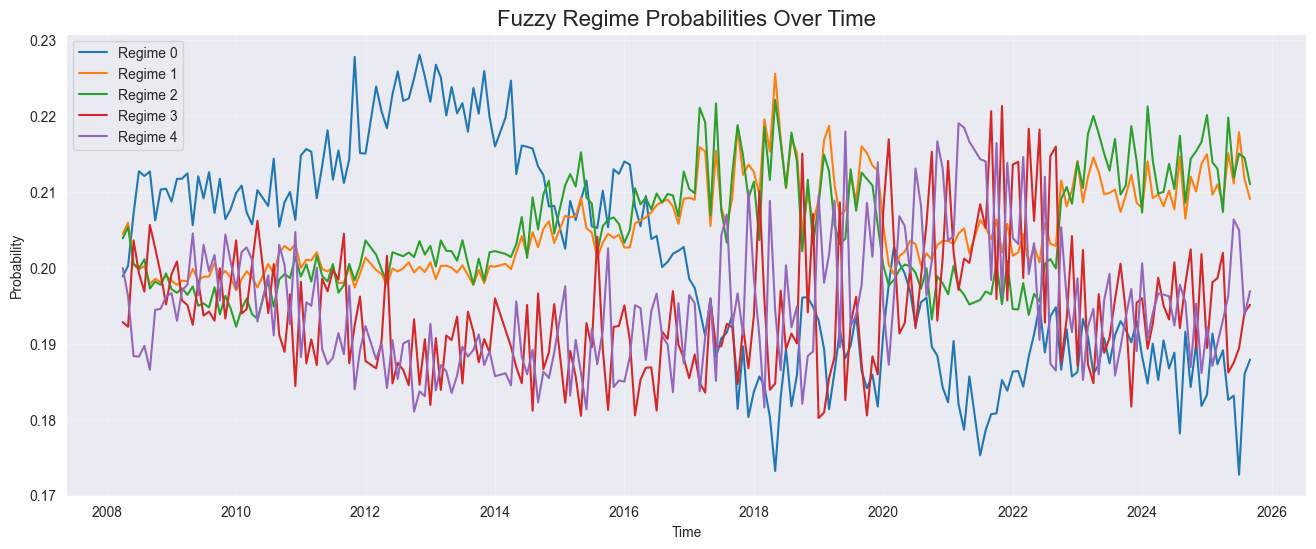

In [66]:
plt.figure(figsize=(16, 6))

for col in prob_df.columns:
    plt.plot(prob_df.index.to_timestamp(), prob_df[col], label=f"Regime {col}")

plt.title("Fuzzy Regime Probabilities Over Time", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [67]:
prob_df

,0,1,2,3,4
2008-04,0.198856,0.204473,0.203885,0.192817,0.199970
2008-05,0.200253,0.205945,0.205360,0.192219,0.196223
2008-06,0.207126,0.200384,0.200533,0.203603,0.188353
2008-07,0.212720,0.199793,0.199878,0.199330,0.188280
2008-08,0.212101,0.200225,0.201123,0.196848,0.189703
...,...,...,...,...,...
2025-05,0.182580,0.215124,0.219818,0.186190,0.196288
2025-06,0.183141,0.211115,0.211876,0.187489,0.206380
2025-07,0.172711,0.217872,0.215054,0.189403,0.204960
2025-08,0.185982,0.211653,0.214504,0.194110,0.193750


In [70]:
kmeans_layer2.cluster_centers_

array([[ 1.42770395e+00, -3.25931290e-01, -9.20903462e-01,
        -4.98184841e-01, -1.58276311e-01,  2.52727588e-02,
         1.54673322e-02, -1.08370700e-01,  1.08815162e-01,
         8.36755185e-02, -1.65805975e-01,  6.18052901e-04],
       [ 7.55724414e-01, -2.57603836e+00,  1.11972021e+00,
         9.84531080e-01,  3.26448913e-02,  2.41770040e-01,
        -3.41582317e-01,  2.90879592e-01, -6.85936326e-01,
         2.18571925e-01,  4.35405233e-01,  6.13977800e-02],
       [ 2.35889366e+00,  3.24633454e-01,  2.01526221e+00,
        -4.80142663e-01,  5.22463838e-01, -7.27097111e-01,
         4.30541758e-02, -3.28557405e-01, -9.67025959e-02,
         2.61317399e-03,  5.26367027e-01, -2.02100994e-01]])